## Paths

In [1]:
dataset_path = "/home/juliamatos/Área de Trabalho/trabalhoCNN/datasets/SimpleSoyNet"
tensorboard_path = "logs/"
models_path = "./models/SoyNet/"

## Dataloader

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def my_tensor_image_show ( image , label=None ):
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.axis('off')
    if label is None :
        plt.title('Image in tensor format.')
    else :
        plt.title(f'Image in tensor format | Class: {label:2d}')
    plt.show()    

In [3]:
# Carrega a ResNet do PyTorch

import torch
from torchvision.models import ResNet, ResNet101_Weights, resnet101


# Transformações para a ResNet101
my_transform = ResNet101_Weights.DEFAULT.transforms()


In [4]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset


# Função para dividir o dataset em treino e teste
def train_test_dataset(dataset, test_split=0.25):
    train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=test_split)
    train_data = Subset(dataset, train_idx)
    test_data = Subset(dataset, test_idx)
    return train_data, test_data

In [5]:
import torch
from torchvision.datasets import ImageFolder


# Carrega o dataset de imagens com as transformações definidas
data = ImageFolder(root=dataset_path, transform=my_transform)

# Divide o dataset em treino e teste
train_data, test_data = train_test_dataset(data, 0.30)

# Cria DataLoaders para treino e teste
batch_size = 512

train_tensors = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_tensors = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

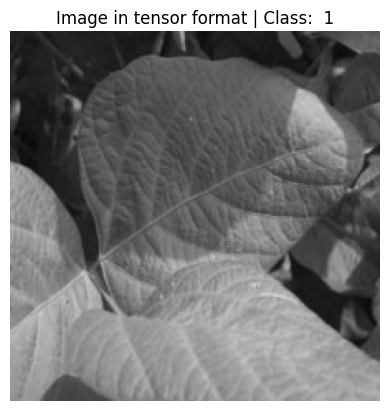

In [6]:
images, labels = next(iter(train_tensors))
my_tensor_image_show(images[0], label=labels[0])

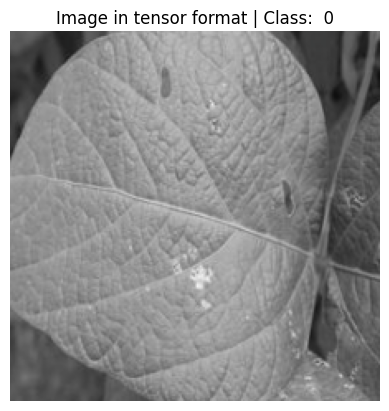

In [7]:
images, labels = next(iter(test_tensors))
my_tensor_image_show(images[0], label=labels[0])

## Train

In [8]:
def validate ( model , data , device='cpu') :

    model.eval()

    correct = 0
    sum = 0
    
    for idx, (test_x, test_label) in enumerate(data) : 
        test_x = test_x.to(device)
        test_label = test_label.to(device)
        predict_y = model( test_x ).detach()
        predict_ys = torch.max( predict_y, axis=1 )[1]
        sum = sum + test_x.size(0)
        correct = correct + torch.sum(predict_ys == test_label)
        correct = correct.cpu().item()
    
    return correct*100./sum

In [9]:
from torch.utils.tensorboard import SummaryWriter

import torch.optim 
import matplotlib.pyplot as plt
  
from datetime import datetime

from tqdm import tqdm

import copy
"""
def plot_layers ( net , writer, epoch ) :
    layers = list(net.fc.modules())
    
    layer_id = 1
    for layer in layers:
        if isinstance(layer, torch.nn.Linear) :

#             writer.add_histogram('Bias/conv{}'.format(layer_id), layer.bias, 
#                                 epoch )
            writer.add_histogram('Weight/conv{}'.format(layer_id), layer.weight, 
                                epoch )
#             writer.add_histogram('Grad/conv{}'.format(layer_id), layer.weight.grad, 
#                                     epoch )
            layer_id += 1
"""
def plot_layers(net, writer, epoch):
    # A ResNet101 tem a última camada como 'fc'
    if hasattr(net, "fc"):
        layer = net.fc
        if isinstance(layer, torch.nn.Linear):
            writer.add_histogram('Weight/fc', layer.weight, epoch)
            if layer.bias is not None:
                writer.add_histogram('Bias/fc', layer.bias, epoch)



def train ( train_loader, test_loader, net, dataset_size, my_device='cpu',
           prefix=None, upper_bound=100.0, save=False, epochs=100, 
           lr=1e-1, device='cpu', debug=False, layers2tensorboard=False , batch_size=64) :

    optimizer = torch.optim.SGD(net.parameters(),lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    
    
    now = datetime.now()
    suffix = now.strftime("%Y%m%d_%H%M%S")
    prefix = suffix if prefix is None else prefix + '-' + suffix  
    
    writer = SummaryWriter( log_dir=tensorboard_path+prefix )
    

        
    accuracies = []
    max_accuracy = -1.0  

    for epoch in tqdm(range(epochs), desc='Training epochs...') :
        net.train()
        for idx, (train_x, train_label) in enumerate(train_loader):
            train_x = train_x.to(device)
            train_label = train_label.to(device)

            predict_y = net( train_x )
            
            # Loss:
            error = criterion( predict_y , train_label )

            writer.add_scalar( 'Loss/train', error.cpu().item(), 
                                idx+( epoch*(dataset_size//batch_size) ) )

            # Back propagation
            optimizer.zero_grad()
            error.backward()
            optimizer.step()
            
            # Accuracy:
            predict_ys = torch.max( predict_y, axis=1 )[1]
            correct    = torch.sum(predict_ys == train_label)

            writer.add_scalar( 'Accuracy/train', correct/train_x.size(0), 
                                idx+( epoch*(dataset_size//batch_size) ) )

            if debug and idx % 10 == 0 :
                print( f'idx: {idx:4d}, _error: {error.cpu().item():5.2f}' )

        if layers2tensorboard :
            plot_layers( net, writer, epoch )

        accuracy = validate(net, test_loader, device=device)
        accuracies.append(accuracy)
        writer.add_scalar( 'Accuracy/test', accuracy, epoch )
        
        if accuracy > max_accuracy :
            best_model = copy.deepcopy(net)
            max_accuracy = accuracy
            print("Saving Best Model with Accuracy: ", accuracy)
        
        print( f'Epoch: {epoch+1:3d} | Accuracy : {accuracy:7.4f}%' )

        if accuracy > upper_bound :
            break
    
    if save : 
        dataset = "SoyNet"
        path = f'{models_path}ResNet101-{dataset}-{max_accuracy:.2f}.pkl'
        torch.save(best_model, path)
        print('Model saved in:',path)
    
    plt.plot(accuracies)

    writer.flush()
    writer.close()
    
    return best_model    

## Run with ResNet101

In [10]:
model = resnet101(weights=ResNet101_Weights.IMAGENET1K_V1)

In [11]:
# Check which layers are frozen
for name, param in model.named_parameters():
    print(f"{name}")

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.conv3.weight
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.downsample.0.weight
layer1.0.downsample.1.weight
layer1.0.downsample.1.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.conv3.weight
layer1.1.bn3.weight
layer1.1.bn3.bias
layer1.2.conv1.weight
layer1.2.bn1.weight
layer1.2.bn1.bias
layer1.2.conv2.weight
layer1.2.bn2.weight
layer1.2.bn2.bias
layer1.2.conv3.weight
layer1.2.bn3.weight
layer1.2.bn3.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.conv3.weight
layer2.0.bn3.weight
layer2.0.bn3.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.we

In [12]:
# Congela  os parâmetros da ResNet18, exceto a última camada
for param in model.parameters():
    param.requires_grad = False

for param in model.layer4.parameters():
    param.requires_grad = True

# Modifica a última camada para o número de classes do dataset
num_classes = 2
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

In [13]:
# Check which layers are frozen
for name, param in model.named_parameters():
    status = "Trainable" if param.requires_grad else "Frozen"
    print(f"{name}: {status}")

conv1.weight: Frozen
bn1.weight: Frozen
bn1.bias: Frozen
layer1.0.conv1.weight: Frozen
layer1.0.bn1.weight: Frozen
layer1.0.bn1.bias: Frozen
layer1.0.conv2.weight: Frozen
layer1.0.bn2.weight: Frozen
layer1.0.bn2.bias: Frozen
layer1.0.conv3.weight: Frozen
layer1.0.bn3.weight: Frozen
layer1.0.bn3.bias: Frozen
layer1.0.downsample.0.weight: Frozen
layer1.0.downsample.1.weight: Frozen
layer1.0.downsample.1.bias: Frozen
layer1.1.conv1.weight: Frozen
layer1.1.bn1.weight: Frozen
layer1.1.bn1.bias: Frozen
layer1.1.conv2.weight: Frozen
layer1.1.bn2.weight: Frozen
layer1.1.bn2.bias: Frozen
layer1.1.conv3.weight: Frozen
layer1.1.bn3.weight: Frozen
layer1.1.bn3.bias: Frozen
layer1.2.conv1.weight: Frozen
layer1.2.bn1.weight: Frozen
layer1.2.bn1.bias: Frozen
layer1.2.conv2.weight: Frozen
layer1.2.bn2.weight: Frozen
layer1.2.bn2.bias: Frozen
layer1.2.conv3.weight: Frozen
layer1.2.bn3.weight: Frozen
layer1.2.bn3.bias: Frozen
layer2.0.conv1.weight: Frozen
layer2.0.bn1.weight: Frozen
layer2.0.bn1.bias: F

Running on cuda


Training epochs...:   1%|          | 1/100 [00:21<35:48, 21.70s/it]

Saving Best Model with Accuracy:  87.62557077625571
Epoch:   1 | Accuracy : 87.6256%


Training epochs...:   2%|▏         | 2/100 [00:42<34:19, 21.01s/it]

Epoch:   2 | Accuracy : 87.6256%


Training epochs...:   3%|▎         | 3/100 [01:04<34:41, 21.46s/it]

Epoch:   3 | Accuracy : 87.6256%


Training epochs...:   4%|▍         | 4/100 [01:24<33:36, 21.00s/it]

Epoch:   4 | Accuracy : 87.6256%


Training epochs...:   5%|▌         | 5/100 [01:45<33:04, 20.89s/it]

Epoch:   5 | Accuracy : 87.6256%


Training epochs...:   6%|▌         | 6/100 [02:07<33:17, 21.25s/it]

Epoch:   6 | Accuracy : 87.6256%


Training epochs...:   7%|▋         | 7/100 [02:29<33:21, 21.53s/it]

Epoch:   7 | Accuracy : 87.6256%


Training epochs...:   8%|▊         | 8/100 [02:49<32:25, 21.15s/it]

Epoch:   8 | Accuracy : 87.6256%


Training epochs...:   9%|▉         | 9/100 [03:11<32:23, 21.36s/it]

Epoch:   9 | Accuracy : 87.6256%


Training epochs...:  10%|█         | 10/100 [03:32<31:54, 21.28s/it]

Epoch:  10 | Accuracy : 87.6256%


Training epochs...:  11%|█         | 11/100 [03:53<31:37, 21.33s/it]

Epoch:  11 | Accuracy : 87.6256%


Training epochs...:  12%|█▏        | 12/100 [04:14<31:08, 21.23s/it]

Saving Best Model with Accuracy:  88.12785388127854
Epoch:  12 | Accuracy : 88.1279%


Training epochs...:  13%|█▎        | 13/100 [04:35<30:31, 21.05s/it]

Saving Best Model with Accuracy:  88.58447488584476
Epoch:  13 | Accuracy : 88.5845%


Training epochs...:  14%|█▍        | 14/100 [04:56<30:11, 21.06s/it]

Saving Best Model with Accuracy:  89.08675799086758
Epoch:  14 | Accuracy : 89.0868%


Training epochs...:  15%|█▌        | 15/100 [05:17<29:40, 20.94s/it]

Saving Best Model with Accuracy:  89.63470319634703
Epoch:  15 | Accuracy : 89.6347%


Training epochs...:  16%|█▌        | 16/100 [05:38<29:35, 21.13s/it]

Saving Best Model with Accuracy:  90.13698630136986
Epoch:  16 | Accuracy : 90.1370%


Training epochs...:  17%|█▋        | 17/100 [05:59<29:08, 21.07s/it]

Saving Best Model with Accuracy:  90.6392694063927
Epoch:  17 | Accuracy : 90.6393%


Training epochs...:  18%|█▊        | 18/100 [06:21<28:53, 21.14s/it]

Epoch:  18 | Accuracy : 90.5479%


Training epochs...:  19%|█▉        | 19/100 [06:43<28:59, 21.47s/it]

Saving Best Model with Accuracy:  90.91324200913242
Epoch:  19 | Accuracy : 90.9132%


Training epochs...:  20%|██        | 20/100 [07:04<28:39, 21.50s/it]

Epoch:  20 | Accuracy : 90.9132%


Training epochs...:  21%|██        | 21/100 [07:25<27:59, 21.26s/it]

Saving Best Model with Accuracy:  91.23287671232876
Epoch:  21 | Accuracy : 91.2329%


Training epochs...:  22%|██▏       | 22/100 [07:47<27:45, 21.36s/it]

Saving Best Model with Accuracy:  91.96347031963471
Epoch:  22 | Accuracy : 91.9635%


Training epochs...:  23%|██▎       | 23/100 [08:08<27:29, 21.42s/it]

Saving Best Model with Accuracy:  92.46575342465754
Epoch:  23 | Accuracy : 92.4658%


Training epochs...:  24%|██▍       | 24/100 [08:30<27:04, 21.37s/it]

Saving Best Model with Accuracy:  93.65296803652969
Epoch:  24 | Accuracy : 93.6530%


Training epochs...:  25%|██▌       | 25/100 [08:51<26:35, 21.27s/it]

Saving Best Model with Accuracy:  93.97260273972603
Epoch:  25 | Accuracy : 93.9726%


Training epochs...:  26%|██▌       | 26/100 [09:12<26:14, 21.27s/it]

Saving Best Model with Accuracy:  94.15525114155251
Epoch:  26 | Accuracy : 94.1553%


Training epochs...:  27%|██▋       | 27/100 [09:33<26:00, 21.37s/it]

Saving Best Model with Accuracy:  94.24657534246575
Epoch:  27 | Accuracy : 94.2466%


Training epochs...:  28%|██▊       | 28/100 [09:55<25:31, 21.28s/it]

Saving Best Model with Accuracy:  94.337899543379
Epoch:  28 | Accuracy : 94.3379%


Training epochs...:  29%|██▉       | 29/100 [10:15<25:01, 21.15s/it]

Epoch:  29 | Accuracy : 94.2922%


Training epochs...:  30%|███       | 30/100 [10:36<24:32, 21.03s/it]

Saving Best Model with Accuracy:  94.42922374429224
Epoch:  30 | Accuracy : 94.4292%


Training epochs...:  31%|███       | 31/100 [10:57<24:14, 21.08s/it]

Epoch:  31 | Accuracy : 94.3836%


Training epochs...:  32%|███▏      | 32/100 [11:18<23:51, 21.05s/it]

Epoch:  32 | Accuracy : 94.3836%


Training epochs...:  33%|███▎      | 33/100 [11:39<23:31, 21.07s/it]

Saving Best Model with Accuracy:  94.52054794520548
Epoch:  33 | Accuracy : 94.5205%


Training epochs...:  34%|███▍      | 34/100 [12:00<23:10, 21.07s/it]

Epoch:  34 | Accuracy : 94.5205%


Training epochs...:  35%|███▌      | 35/100 [12:22<22:58, 21.21s/it]

Epoch:  35 | Accuracy : 94.5205%


Training epochs...:  36%|███▌      | 36/100 [12:43<22:39, 21.25s/it]

Saving Best Model with Accuracy:  94.5662100456621
Epoch:  36 | Accuracy : 94.5662%


Training epochs...:  37%|███▋      | 37/100 [13:04<22:14, 21.19s/it]

Epoch:  37 | Accuracy : 94.5662%


Training epochs...:  38%|███▊      | 38/100 [13:25<21:44, 21.04s/it]

Epoch:  38 | Accuracy : 94.5662%


Training epochs...:  39%|███▉      | 39/100 [13:46<21:16, 20.93s/it]

Epoch:  39 | Accuracy : 94.5662%


Training epochs...:  40%|████      | 40/100 [14:07<21:01, 21.02s/it]

Epoch:  40 | Accuracy : 94.5662%


Training epochs...:  41%|████      | 41/100 [14:28<20:43, 21.08s/it]

Epoch:  41 | Accuracy : 94.5662%


Training epochs...:  42%|████▏     | 42/100 [14:50<20:34, 21.29s/it]

Epoch:  42 | Accuracy : 94.5662%


Training epochs...:  43%|████▎     | 43/100 [15:12<20:23, 21.47s/it]

Epoch:  43 | Accuracy : 94.5662%


Training epochs...:  44%|████▍     | 44/100 [15:33<19:50, 21.26s/it]

Saving Best Model with Accuracy:  94.79452054794521
Epoch:  44 | Accuracy : 94.7945%


Training epochs...:  45%|████▌     | 45/100 [15:54<19:32, 21.31s/it]

Epoch:  45 | Accuracy : 94.7945%


Training epochs...:  46%|████▌     | 46/100 [16:15<19:06, 21.24s/it]

Saving Best Model with Accuracy:  95.0228310502283
Epoch:  46 | Accuracy : 95.0228%


Training epochs...:  47%|████▋     | 47/100 [16:36<18:45, 21.24s/it]

Epoch:  47 | Accuracy : 95.0228%


Training epochs...:  48%|████▊     | 48/100 [16:58<18:25, 21.27s/it]

Epoch:  48 | Accuracy : 95.0228%


Training epochs...:  49%|████▉     | 49/100 [17:19<18:03, 21.24s/it]

Epoch:  49 | Accuracy : 95.0228%


Training epochs...:  50%|█████     | 50/100 [17:40<17:33, 21.07s/it]

Epoch:  50 | Accuracy : 95.0228%


Training epochs...:  51%|█████     | 51/100 [18:02<17:28, 21.41s/it]

Epoch:  51 | Accuracy : 95.0228%


Training epochs...:  52%|█████▏    | 52/100 [18:22<16:51, 21.07s/it]

Epoch:  52 | Accuracy : 95.0228%


Training epochs...:  53%|█████▎    | 53/100 [18:43<16:23, 20.92s/it]

Saving Best Model with Accuracy:  95.06849315068493
Epoch:  53 | Accuracy : 95.0685%


Training epochs...:  54%|█████▍    | 54/100 [19:03<15:51, 20.69s/it]

Epoch:  54 | Accuracy : 95.0685%


Training epochs...:  55%|█████▌    | 55/100 [19:25<15:49, 21.10s/it]

Epoch:  55 | Accuracy : 95.0685%


Training epochs...:  56%|█████▌    | 56/100 [19:47<15:40, 21.37s/it]

Epoch:  56 | Accuracy : 95.0685%


Training epochs...:  57%|█████▋    | 57/100 [20:08<15:11, 21.20s/it]

Epoch:  57 | Accuracy : 95.0685%


Training epochs...:  58%|█████▊    | 58/100 [20:28<14:42, 21.02s/it]

Epoch:  58 | Accuracy : 95.0228%


Training epochs...:  59%|█████▉    | 59/100 [20:49<14:19, 20.97s/it]

Epoch:  59 | Accuracy : 95.0228%


Training epochs...:  60%|██████    | 60/100 [21:10<14:00, 21.02s/it]

Epoch:  60 | Accuracy : 95.0228%


Training epochs...:  61%|██████    | 61/100 [21:31<13:38, 21.00s/it]

Epoch:  61 | Accuracy : 95.0228%


Training epochs...:  62%|██████▏   | 62/100 [21:52<13:15, 20.95s/it]

Epoch:  62 | Accuracy : 95.0228%


Training epochs...:  63%|██████▎   | 63/100 [22:13<12:51, 20.85s/it]

Saving Best Model with Accuracy:  95.15981735159818
Epoch:  63 | Accuracy : 95.1598%


Training epochs...:  64%|██████▍   | 64/100 [22:33<12:27, 20.75s/it]

Epoch:  64 | Accuracy : 95.1598%


Training epochs...:  65%|██████▌   | 65/100 [22:54<12:07, 20.77s/it]

Epoch:  65 | Accuracy : 95.1598%


Training epochs...:  66%|██████▌   | 66/100 [23:15<11:45, 20.76s/it]

Epoch:  66 | Accuracy : 95.1598%


Training epochs...:  67%|██████▋   | 67/100 [23:35<11:19, 20.59s/it]

Saving Best Model with Accuracy:  95.57077625570776
Epoch:  67 | Accuracy : 95.5708%


Training epochs...:  68%|██████▊   | 68/100 [23:56<10:59, 20.62s/it]

Epoch:  68 | Accuracy : 95.5708%


Training epochs...:  69%|██████▉   | 69/100 [24:17<10:43, 20.75s/it]

Epoch:  69 | Accuracy : 95.5708%


Training epochs...:  70%|███████   | 70/100 [24:37<10:23, 20.77s/it]

Epoch:  70 | Accuracy : 95.5708%


Training epochs...:  71%|███████   | 71/100 [24:59<10:06, 20.91s/it]

Saving Best Model with Accuracy:  95.662100456621
Epoch:  71 | Accuracy : 95.6621%


Training epochs...:  72%|███████▏  | 72/100 [25:19<09:43, 20.84s/it]

Epoch:  72 | Accuracy : 95.5708%


Training epochs...:  73%|███████▎  | 73/100 [25:40<09:18, 20.69s/it]

Epoch:  73 | Accuracy : 95.6621%


Training epochs...:  74%|███████▍  | 74/100 [26:00<08:57, 20.69s/it]

Epoch:  74 | Accuracy : 95.5708%


Training epochs...:  75%|███████▌  | 75/100 [26:21<08:39, 20.79s/it]

Epoch:  75 | Accuracy : 95.6621%


Training epochs...:  76%|███████▌  | 76/100 [26:43<08:23, 21.00s/it]

Saving Best Model with Accuracy:  95.79908675799086
Epoch:  76 | Accuracy : 95.7991%


Training epochs...:  77%|███████▋  | 77/100 [27:04<08:02, 20.98s/it]

Epoch:  77 | Accuracy : 95.6621%


Training epochs...:  78%|███████▊  | 78/100 [27:25<07:39, 20.89s/it]

Saving Best Model with Accuracy:  95.98173515981735
Epoch:  78 | Accuracy : 95.9817%


Training epochs...:  79%|███████▉  | 79/100 [27:47<07:26, 21.28s/it]

Epoch:  79 | Accuracy : 95.9817%


Training epochs...:  80%|████████  | 80/100 [28:07<07:00, 21.05s/it]

Epoch:  80 | Accuracy : 95.9817%


Training epochs...:  81%|████████  | 81/100 [28:29<06:41, 21.14s/it]

Epoch:  81 | Accuracy : 95.9817%


Training epochs...:  82%|████████▏ | 82/100 [28:50<06:20, 21.12s/it]

Epoch:  82 | Accuracy : 95.9817%


Training epochs...:  83%|████████▎ | 83/100 [29:11<06:00, 21.22s/it]

Epoch:  83 | Accuracy : 95.8904%


Training epochs...:  84%|████████▍ | 84/100 [29:32<05:38, 21.17s/it]

Epoch:  84 | Accuracy : 95.9817%


Training epochs...:  85%|████████▌ | 85/100 [29:54<05:19, 21.30s/it]

Epoch:  85 | Accuracy : 95.8904%


Training epochs...:  86%|████████▌ | 86/100 [30:16<05:00, 21.48s/it]

Epoch:  86 | Accuracy : 95.9817%


Training epochs...:  87%|████████▋ | 87/100 [30:37<04:37, 21.32s/it]

Epoch:  87 | Accuracy : 95.8904%


Training epochs...:  88%|████████▊ | 88/100 [30:57<04:12, 21.03s/it]

Epoch:  88 | Accuracy : 95.9817%


Training epochs...:  89%|████████▉ | 89/100 [31:18<03:52, 21.13s/it]

Epoch:  89 | Accuracy : 95.8904%


Training epochs...:  90%|█████████ | 90/100 [31:40<03:33, 21.35s/it]

Epoch:  90 | Accuracy : 95.8904%


Training epochs...:  91%|█████████ | 91/100 [32:02<03:12, 21.42s/it]

Epoch:  91 | Accuracy : 95.8904%


Training epochs...:  92%|█████████▏| 92/100 [32:22<02:49, 21.20s/it]

Epoch:  92 | Accuracy : 95.8904%


Training epochs...:  93%|█████████▎| 93/100 [32:43<02:27, 21.03s/it]

Epoch:  93 | Accuracy : 95.8447%


Training epochs...:  94%|█████████▍| 94/100 [33:04<02:05, 20.90s/it]

Epoch:  94 | Accuracy : 95.8447%


Training epochs...:  95%|█████████▌| 95/100 [33:25<01:44, 20.96s/it]

Epoch:  95 | Accuracy : 95.8447%


Training epochs...:  96%|█████████▌| 96/100 [33:46<01:23, 20.91s/it]

Epoch:  96 | Accuracy : 95.7534%


Training epochs...:  97%|█████████▋| 97/100 [34:07<01:02, 20.95s/it]

Epoch:  97 | Accuracy : 95.7534%


Training epochs...:  98%|█████████▊| 98/100 [34:27<00:41, 20.90s/it]

Epoch:  98 | Accuracy : 95.7534%


Training epochs...:  99%|█████████▉| 99/100 [34:49<00:21, 21.01s/it]

Epoch:  99 | Accuracy : 95.7534%


Training epochs...: 100%|██████████| 100/100 [35:09<00:00, 21.10s/it]

Epoch: 100 | Accuracy : 95.8904%
Model saved in: ./models/SoyNet/ResNet101-SoyNet-95.98.pkl


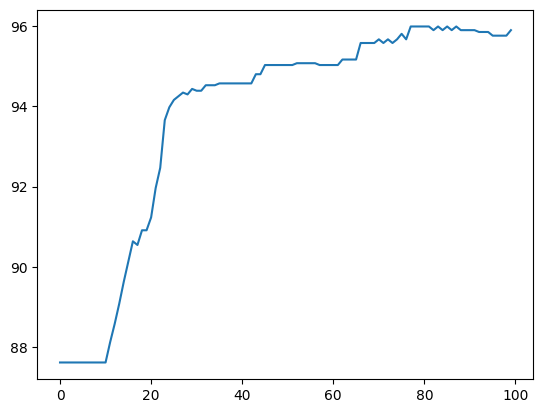

In [14]:
if torch.cuda.is_available():
    my_device = torch.device("cuda:0")
else:
    my_device = torch.device("cpu")

print(f"Running on {my_device.type}")
    
model = model.to(my_device)

epochs = 100
lr = 1e-3
dataset = 'SoyNet'
prefix = 'ResNet101-FT-{}-e-{}-lr-{}'.format(dataset, epochs, lr)

net = train(train_tensors, test_tensors, model, len(train_data),
            epochs=epochs, device=my_device, save=True, 
            prefix=prefix, lr=lr, layers2tensorboard=True, batch_size=batch_size)

Sample id: 210
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
Hit
0
Predicted: Disease | Corrected: Disease | Confidence: 99.91%


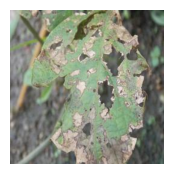

In [16]:
import numpy as np
def sample_and_predict ( net, seed=None ) :

    if seed is not None :
        np.random.seed(seed)

    dataset = ImageFolder(root=dataset_path, transform=None)

    data = train_test_dataset(dataset, 0.30)[1]
    
    my_transform = ResNet101_Weights.DEFAULT.transforms()
    i = np.random.randint(len(data))
    
    sample = data[i][0]
    plt.figure(figsize=(2,2))
    plt.axis('off')
    plt.imshow( sample )

    print( f'Sample id: {i:3d}' )
    
    x = my_transform(sample)
    print(x.shape)

    x = x.unsqueeze_(0)
    print(x.shape)

    x = x.to(my_device)
    
    output = net ( x )
    predictions = output.squeeze(0).softmax(0)
        
    predicted_class = torch.argmax(predictions)
    predicted_class = predicted_class.data.cpu().item()
    
    confidence = predictions[predicted_class]
    confidence = confidence.data.cpu().item()
    
    dataset_classes = ["Disease", "Healthy"]

    if predicted_class == data[i][1] : print('Hit')
    else: print('Miss')

    print(predicted_class)
    print( f'Predicted: {dataset_classes[predicted_class]} | Corrected: {dataset_classes[data[i][1]]} | Confidence: {confidence*100:.2f}%'  )
    
    # return dataset_classes[y], dataset_classes[data[i][1]], confidence

sample_and_predict(net)
